<a href="https://colab.research.google.com/github/TakaNori999/ML_Class/blob/main/ResNet50_fineturning_3_Grad_CAM_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# データセットのパス
train_data_dir = '/content/drive/MyDrive/dog_cat_images/'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt

In [ ]:
# ImageDataGeneratorを使って画像を読み込み、前処理を行う
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # ResNet50の前処理関数を適用
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# トレーニングデータセットを作成
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224), # ResNet50の入力サイズにリサイズ
    batch_size=32,
    class_mode='binary'
)

Found 99 images belonging to 2 classes.


In [ ]:
# ImageNetで学習済みのResNet50を読み込む（最終層は含めない）
base_model = ResNet50(weights='imagenet', include_top=False)

# 最終層を追加
x = base_model.output
x = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', name='my_conv_layer')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

In [ ]:
# 新しいモデルを作成
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# ファインチューニング：ResNet50の最終層だけ学習
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 42,464,129 (161.99 MB)

 Trainable params: 18,876,417 (72.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ファインチューニングの実行
model.fit(train_generator, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 940ms/step - accuracy: 0.5571 - loss: 15.0148
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.6849 - loss: 1.4010
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.7804 - loss: 0.3243
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.9908 - loss: 0.0787
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.9873 - loss: 0.0401


In [ ]:
# 推論
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print("Prediction: Dog")
    else:
        print("Prediction: Cat")
    return img_array

In [ ]:
image_path = '/content/drive/MyDrive/image_test/test_10.jpg' # 推論したい画像のパス

In [ ]:
# 画像の前処理
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # load_imgを使用
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

In [ ]:
# Grad-CAMを計算する関数
def grad_cam(input_model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [input_model.inputs],
        [input_model.get_layer(layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # 正規化
    return heatmap, class_idx.numpy()

In [ ]:
# Grad-CAMのヒートマップを重ねる関数
def overlay_heatmap(heatmap, original_image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [ ]:
# 外部画像の前処理
img_array = preprocess_image(image_path)
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


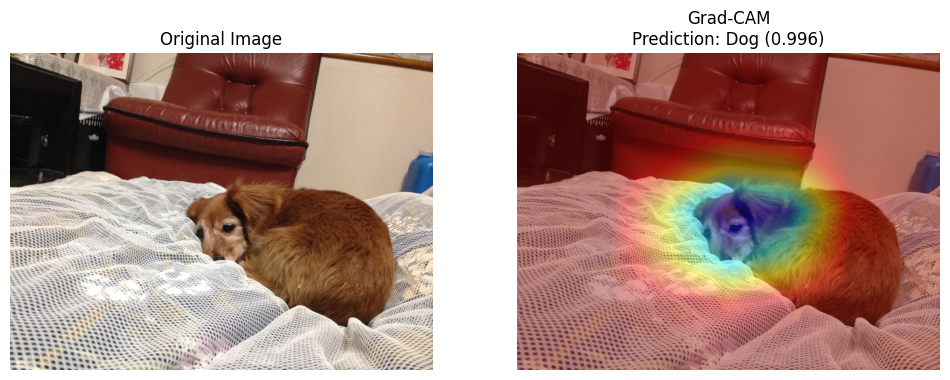

In [ ]:
layer_name = 'my_conv_layer'
heatmap, predicted_class = grad_cam(model, img_array, layer_name)
overlay = overlay_heatmap(heatmap, original_image)

# モデルの出力から予測結果を取得
prediction = model.predict(img_array)[0][0]
predicted_label = "Dog" if prediction > 0.5 else "cat"
if predicted_label == "Dog":
  probability = prediction
else:
  probability = 1 - prediction

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM\nPrediction: {predicted_label} ({probability:.3f})") # タイトルを変更
plt.axis("off")

plt.show()